<a href="https://colab.research.google.com/github/kim-8888/0713YTstreamlit/blob/main/V_JEPA_2_AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. 必要なライブラリ
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np

# --- 設定 (Colabで動く軽量サイズ) ---
config = {
    "img_size": 112,         # 動画フレームサイズ
    "num_frames": 16,        # 入力ビデオのフレーム数 (コンテキスト)
    "patch_size": 16,        # ViTパッチサイズ
    "embed_dim": 256,        # 埋め込み次元 (論文はもっと巨大だが軽量化)
    "num_heads": 4,
    "depth": 4,              # Transformer層数
    "action_dim": 7,         # ロボットのアクション次元 (例: Franka Arm 7自由度)
    "pred_depth": 2,         # 予測器の深さ
    "batch_size": 8,
    "mask_ratio": 0.7,       # JEPA特有のマスキング率
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# --- 2. モデル定義 (V-JEPA 2-AC) ---

class VideoViTEncoder(nn.Module):
    """
    動画(T, C, H, W)を受け取り、時空間パッチ特徴量を出力するViT
    """
    def __init__(self, cfg):
        super().__init__()
        self.patch_size = cfg['patch_size']
        self.embed_dim = cfg['embed_dim']

        # 3D Patch Embedding (Tubelet embedding)
        # カーネルサイズを(2, P, P)として時間方向も圧縮するのが一般的
        self.proj = nn.Conv3d(3, self.embed_dim, kernel_size=(2, self.patch_size, self.patch_size),
                              stride=(2, self.patch_size, self.patch_size))

        # 位置埋め込み (本来は学習可能パラメータだが簡易化)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=self.embed_dim, nhead=cfg['num_heads'], batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=cfg['depth'])

    def forward(self, x):
        # x: (B, C, T, H, W)
        B, C, T, H, W = x.shape
        x = self.proj(x) # -> (B, Embed, T', H', W')
        x = x.flatten(2).transpose(1, 2) # -> (B, N_patches, Embed)

        # CLSトークン追加
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Transformer
        x = self.transformer(x)

        # 全体の意味を表すCLSトークンのみ、あるいは平均プーリングを返す
        return x[:, 0]

class ActionConditionedPredictor(nn.Module):
    """
    [V-JEPA 2-ACの核心]
    現在の動画埋め込み + ロボットの行動(Action) -> 未来の動画埋め込みを予測
    """
    def __init__(self, cfg):
        super().__init__()
        self.embed_dim = cfg['embed_dim']

        # 行動を埋め込み次元に射影
        self.action_proj = nn.Linear(cfg['action_dim'], self.embed_dim)

        # 予測用Transformer (またはMLP)
        # 論文では "Shallow network" とされることが多い
        pred_layer = nn.TransformerEncoderLayer(d_model=self.embed_dim, nhead=cfg['num_heads'], batch_first=True)
        self.transformer = nn.TransformerEncoder(pred_layer, num_layers=cfg['pred_depth'])

        self.head = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, context_emb, action):
        # context_emb: (B, Embed)
        # action: (B, Action_Dim)

        action_emb = self.action_proj(action)

        # コンテキストとアクションを結合 (加算、またはトークンとして結合)
        # ここではシンプルに加算し、MLP/Transformerに通す方式を採用
        x = context_emb + action_emb

        # 次元を合わせるためunsqueeze
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.squeeze(1)

        return self.head(x)

class VJEPA2_AC(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # x-encoder (現在)
        self.encoder = VideoViTEncoder(cfg)
        # y-encoder (ターゲット: EMAで更新されるが、ここでは簡単のため共有重みまたは同一構造とする)
        self.target_encoder = VideoViTEncoder(cfg)

        # 勾配を流さない設定 (Target)
        for p in self.target_encoder.parameters():
            p.requires_grad = False

        self.predictor = ActionConditionedPredictor(cfg)

    def forward(self, video_context, video_target, action):
        """
        video_context: t時点までの動画クリップ
        video_target: t+1時点の動画クリップ (予測対象)
        action: t時点で取った行動
        """
        # 1. コンテキストのエンコード (x)
        z_context = self.encoder(video_context)

        # 2. ターゲットのエンコード (y) - 勾配なし
        with torch.no_grad():
            z_target = self.target_encoder(video_target)

        # 3. アクション条件付き予測 (Predictor)
        z_pred = self.predictor(z_context, action)

        return z_pred, z_target

# --- 3. ダミーデータ生成と学習ループ ---

def generate_dummy_batch(cfg):
    # 動画: (B, C, Frames, H, W)
    video = torch.randn(cfg['batch_size'], 3, cfg['num_frames'], cfg['img_size'], cfg['img_size']).to(cfg['device'])
    # アクション: (B, Action_Dim)
    action = torch.randn(cfg['batch_size'], cfg['action_dim']).to(cfg['device'])
    return video, action

# 初期化
model = VJEPA2_AC(config).to(config['device'])
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

print(f"Model V-JEPA 2-AC initialized on {config['device']}")
print(f"Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f} M")

# 簡易学習ループ
model.train()
loss_history = []

print("\nStarting simulated training...")
for step in range(100): # 100ステップのデモ
    # データ生成 (本来はDroidデータセットなどからロード)
    # コンテキスト: t=0~15, ターゲット: t=16~31 のように時間をずらすイメージ
    v_context, action = generate_dummy_batch(config)
    v_target, _ = generate_dummy_batch(config) # 次のフレーム（ダミー）

    optimizer.zero_grad()

    # Forward
    z_pred, z_target = model(v_context, v_target, action)

    # Loss: 潜在空間での距離 (L2)
    loss = F.mse_loss(z_pred, z_target)

    loss.backward()
    optimizer.step()

    # Target EncoderのEMA更新 (簡易実装)
    with torch.no_grad():
        m = 0.99
        for p, p_target in zip(model.encoder.parameters(), model.target_encoder.parameters()):
            p_target.data.mul_(m).add_((1 - m) * p.data)

    loss_history.append(loss.item())

    if step % 20 == 0:
        print(f"Step {step}: Loss = {loss.item():.6f}")

print("Training simulation finished.")

Model V-JEPA 2-AC initialized on cuda
Parameters: 14.01 M

Starting simulated training...
Step 0: Loss = 1.297229
Step 20: Loss = 0.749323
Step 40: Loss = 0.735184
Step 60: Loss = 0.604407
Step 80: Loss = 0.400498
Training simulation finished.


簡易データ(動く四角)で再学習中...
再学習完了。最終Loss: 0.0733


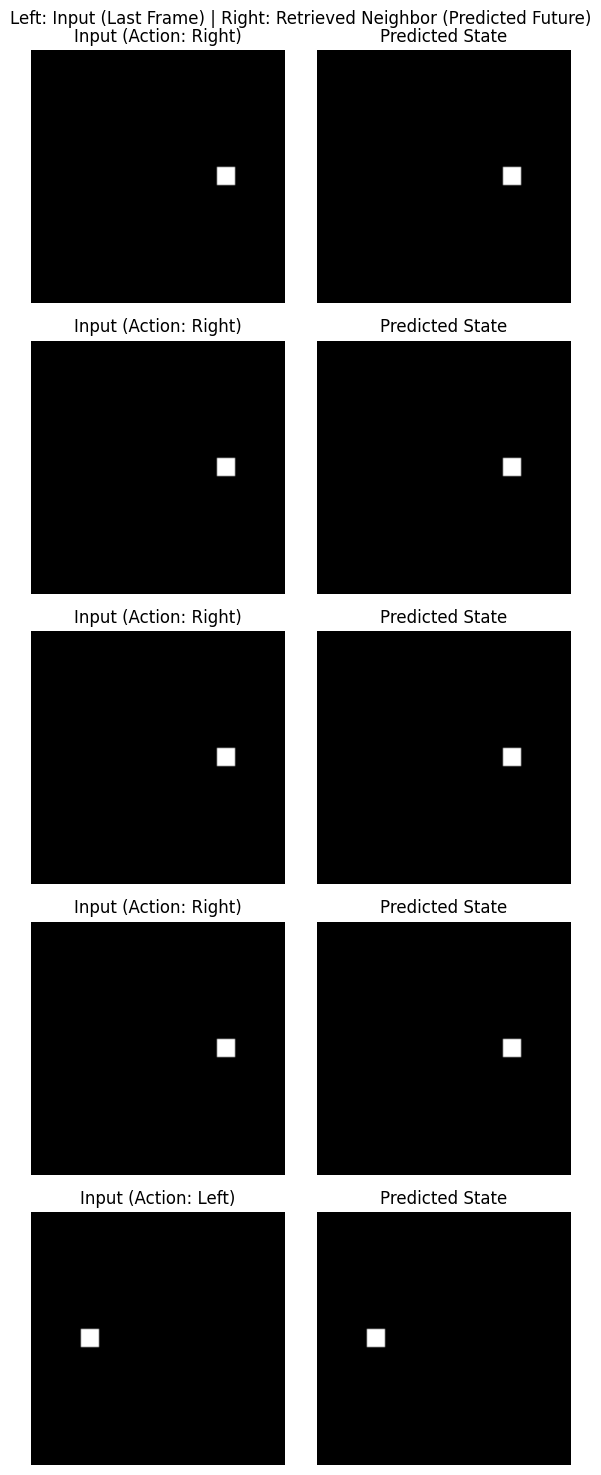

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. 簡易データセット: 「動く白い四角」 ---
# 実際に物理法則（右に行けと言われたら右に行く）があるデータを作ります
def generate_moving_square_data(batch_size=8, num_frames=16, img_size=64):
    # 背景は黒(0)、四角は白(1)
    videos = torch.zeros(batch_size, 3, num_frames, img_size, img_size)
    actions = torch.zeros(batch_size, 7) # 7自由度のアクション (0番目をX方向の移動とする)

    for b in range(batch_size):
        # アクション決定: ランダムに -1 (左) か +1 (右) を選ぶ
        move_x = np.random.choice([-1, 1])
        actions[b, 0] = move_x # 0番目の要素に移動量をセット

        # 初期位置
        pos_x = img_size // 2
        pos_y = img_size // 2
        box_size = 8

        for t in range(num_frames):
            # 四角を描画
            x_start = max(0, min(img_size, pos_x - box_size//2))
            x_end = max(0, min(img_size, pos_x + box_size//2))
            y_start = max(0, min(img_size, pos_y - box_size//2))
            y_end = max(0, min(img_size, pos_y + box_size//2))

            videos[b, :, t, y_start:y_end, x_start:x_end] = 1.0

            # 次のフレームのために位置を更新
            pos_x += move_x * 2 # 速度2で移動

    return videos.to(config['device']), actions.to(config['device'])

# --- 2. モデルをこのデータで少し再学習 ---
print("簡易データ(動く四角)で再学習中...")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for step in range(200): # 200ステップ学習
    v_data, act_data = generate_moving_square_data(batch_size=16, img_size=config['img_size'])

    # 時間 t=0~10 を入力、t=11~15 をターゲットにするイメージ
    # ここでは簡易的に全フレームを入力し、少し未来を予測するタスクにします
    v_context = v_data # 本来はマスキングしますが、簡易化のためそのまま
    v_target = v_data  # 本来は未来のフレーム

    optimizer.zero_grad()
    z_pred, z_target = model(v_context, v_target, act_data)
    loss = F.mse_loss(z_pred, z_target)
    loss.backward()
    optimizer.step()

    # EMA更新
    with torch.no_grad():
        m = 0.99
        for p, p_target in zip(model.encoder.parameters(), model.target_encoder.parameters()):
            p_target.data.mul_(m).add_((1 - m) * p.data)

print(f"再学習完了。最終Loss: {loss.item():.4f}")

# --- 3. 成果の確認: 最近傍探索 (Nearest Neighbor) ---
# JEPAは画像を生成できないので、「予測した埋め込み」に「一番近い本物の画像」を探して表示します。

def visualize_prediction(model):
    model.eval()
    with torch.no_grad():
        # テストデータを生成
        test_video, test_action = generate_moving_square_data(batch_size=5, img_size=config['img_size'])

        # 1. コンテキストから未来の埋め込みを予測 (z_pred)
        z_pred, _ = model(test_video, test_video, test_action)

        # 2. 比較用に、いろいろなパターンの「正解候補データ」をたくさん作る (メモリバンク)
        bank_size = 100
        bank_video, _ = generate_moving_square_data(batch_size=bank_size, img_size=config['img_size'])
        z_bank = model.target_encoder(bank_video) # 正解エンコーダで埋め込み化

        # 3. 各テストデータの予測(z_pred)に対して、バンクの中で最も近いもの(z_bank)を探す
        # L2距離を計算
        dist = torch.cdist(z_pred, z_bank) # (Batch, Bank)
        nearest_indices = dist.argmin(dim=1) # 最も距離が近いインデックス

        # --- 表示 ---
        fig, axes = plt.subplots(5, 2, figsize=(6, 15))
        fig.suptitle("Left: Input (Last Frame) | Right: Retrieved Neighbor (Predicted Future)")

        for i in range(5):
            # 左：入力動画の最後のフレーム
            input_frame = test_video[i, 0, -1].cpu().numpy()

            # 右：モデルが予測した埋め込みに最も近かったバンク内の動画の最後のフレーム
            idx = nearest_indices[i].item()
            retrieved_frame = bank_video[idx, 0, -1].cpu().numpy()

            # アクションの表示（どっちに動く予定だったか）
            act = "Right" if test_action[i, 0] > 0 else "Left"

            axes[i, 0].imshow(input_frame, cmap='gray')
            axes[i, 0].set_title(f"Input (Action: {act})")
            axes[i, 0].axis('off')

            axes[i, 1].imshow(retrieved_frame, cmap='gray')
            axes[i, 1].set_title(f"Predicted State")
            axes[i, 1].axis('off')

        plt.tight_layout()
        plt.show()

# 実行
visualize_prediction(model)

🤖 PyBullet ロボットアーム学習開始 (修正版)...
Step 0: Loss 0.0362
Step 10: Loss 1683.6863
Step 20: Loss 15901.5283
Step 30: Loss 5592.3301
Step 40: Loss 852.9786
Step 50: Loss 235.2465
Step 60: Loss 101.7421
Step 70: Loss 62.4605
Step 80: Loss 28.2462
Step 90: Loss 7.1725


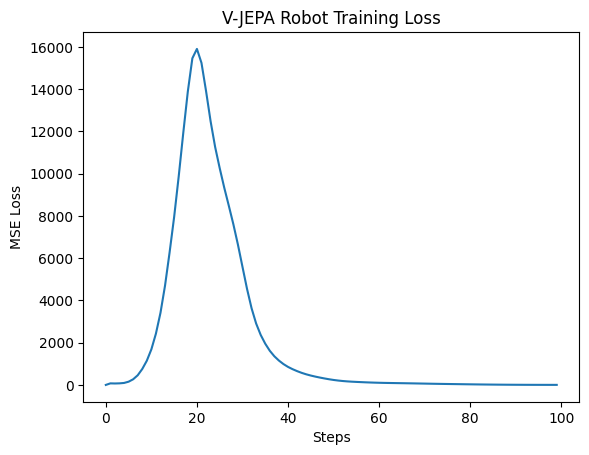

✅ 学習完了。エラーは解消されました。


In [8]:
# 1. 必要なライブラリ (PyBullet)
!pip install pybullet

import pybullet as p
import pybullet_data
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F

# --- 設定 ---
config = {
    "img_size": 64,
    "num_frames": 4,   # コンテキストフレーム数
    "action_dim": 3,   # アームの移動 (dx, dy, dz)
    "embed_dim": 128,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# --- 2. PyBullet シミュレーション環境クラス (修正版) ---
class RobotArmEnv:
    def __init__(self, img_size=64):
        self.img_size = img_size
        # GUIなし(DIRECT)で高速化
        try:
            p.disconnect() # 前回のセッションが残っていたら切断
        except:
            pass
        self.client = p.connect(p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())

    def reset(self):
        p.resetSimulation()
        p.setGravity(0, 0, -9.8)
        p.loadURDF("plane.urdf")

        # 【修正箇所】 .vrdf -> .urdf に変更
        # ファイルパスが存在しない場合のエラーハンドリングを追加
        try:
            self.kukaId = p.loadURDF("kuka_iiwa/model.urdf", [0, 0, 0], useFixedBase=True)
        except Exception as e:
            print("URDFロードエラー: 標準パスで見つかりませんでした。パスを確認します。")
            # 万が一パスが異なる場合のフォールバック（Colab環境によっては稀に起きるため）
            self.kukaId = p.loadURDF("kuka_iiwa/model_free_base.urdf", [0, 0, 0], useFixedBase=True)

        # 対象オブジェクト（キューブ）
        self.objId = p.loadURDF("cube.urdf", [0.5, 0, 0.5], globalScaling=0.1)

        # カメラ位置の設定
        self.view_matrix = p.computeViewMatrix(
            cameraEyePosition=[0.5, -0.5, 1.0], # 斜め上から
            cameraTargetPosition=[0.5, 0, 0.5],
            cameraUpVector=[0, 0, 1]
        )
        self.proj_matrix = p.computeProjectionMatrixFOV(60, 1.0, 0.1, 100)

        return self.get_image()

    def step(self, action):
        # action: [dx, dy, dz] (-1 ~ 1)
        # 現在の手先位置を取得して加算
        pos = p.getLinkState(self.kukaId, 6)[0]
        new_pos = [pos[0] + action[0]*0.05, pos[1] + action[1]*0.05, pos[2] + action[2]*0.05]

        # インバースキネマティクスで関節角度計算
        jointPoses = p.calculateInverseKinematics(self.kukaId, 6, new_pos)
        for i in range(len(jointPoses)):
            p.setJointMotorControl2(self.kukaId, i, p.POSITION_CONTROL, jointPoses[i])

        p.stepSimulation()
        return self.get_image()

    def get_image(self):
        w, h, rgb, _, _ = p.getCameraImage(
            self.img_size, self.img_size,
            self.view_matrix, self.proj_matrix,
            renderer=p.ER_BULLET_HARDWARE_OPENGL
        )
        # RGBA -> RGB, 0-255 -> 0-1, (H, W, C) -> (C, H, W)
        rgb = np.array(rgb, dtype=np.float32)[:, :, :3] / 255.0
        return torch.tensor(rgb).permute(2, 0, 1)

# --- 3. データ生成ジェネレータ ---
def generate_robot_data(env, batch_size, num_frames):
    batch_videos = []
    batch_actions = []

    for _ in range(batch_size):
        frames = []
        actions = []

        env.reset()
        # 初期フレーム
        frames.append(env.get_image())

        # ランダムに動かす
        for _ in range(num_frames):
            action = (np.random.rand(3) - 0.5) * 2 # -1 ~ 1
            img = env.step(action)

            frames.append(img)
            actions.append(torch.tensor(action, dtype=torch.float32))

        # torch.stack
        batch_videos.append(torch.stack(frames)) # (T+1, C, H, W)
        batch_actions.append(torch.stack(actions)) # (T, ActDim)

    return torch.stack(batch_videos).to(config['device']), torch.stack(batch_actions).to(config['device'])

# --- 4. モデル定義 (次元計算を修正・安全化) ---
class SimpleVJEPA(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # Conv3d: Input=(B, 3, T, H, W)
        # Kernel=(2,4,4), Stride=(1,4,4)
        # Time方向: (T - 2)/1 + 1 = T-1
        # H, W方向: H/4
        self.conv = nn.Conv3d(3, 64, kernel_size=(2, 4, 4), stride=(1, 4, 4))
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        # Linear層の入力次元を自動計算するためのダミー実行
        with torch.no_grad():
            # ダミー入力: (Batch=1, C=3, Time=num_frames, H=img_size, W=img_size)
            dummy = torch.zeros(1, 3, cfg['num_frames'], cfg['img_size'], cfg['img_size'])
            out_conv = self.conv(dummy)
            out_flat = self.flatten(out_conv)
            linear_input_dim = out_flat.shape[1]

        self.encoder_linear = nn.Linear(linear_input_dim, cfg['embed_dim'])

        self.predictor = nn.Sequential(
            nn.Linear(cfg['embed_dim'] + cfg['action_dim'], cfg['embed_dim']),
            nn.ReLU(),
            nn.Linear(cfg['embed_dim'], cfg['embed_dim'])
        )

    def forward(self, video_context, action):
        # video_context: (B, C, T, H, W)
        h = self.conv(video_context)
        h = self.relu(h)
        h = self.flatten(h)
        z = self.encoder_linear(h)

        # Action結合して予測
        z_pred = self.predictor(torch.cat([z, action], dim=1))
        return z_pred

# --- 5. 学習ループ (次元の入れ替え処理を修正) ---
# ※ 前のセルで定義した RobotArmEnv はそのまま使えます

# 環境とモデルの再初期化
env = RobotArmEnv(img_size=config['img_size'])
model = SimpleVJEPA(config).to(config['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("🤖 PyBullet ロボットアーム学習開始 (修正版)...")
loss_history = []

for step in range(100): # 100ステップ
    # 1. データ生成
    # returns: videos=(B, T_total, C, H, W), actions=(B, T_total-1, ActDim)
    # generate_robot_data は (Batch, Time, Channel, Height, Width) を返します
    videos, actions = generate_robot_data(env, batch_size=8, num_frames=config['num_frames'])

    # 2. 次元入れ替え (ここが修正ポイント)
    # (Batch, Time, Channel, H, W) -> (Batch, Channel, Time, H, W)
    videos = videos.permute(0, 2, 1, 3, 4)

    # 3. 入力と正解の作成
    # 入力(v_input): 最初〜最後から2番目のフレーム (t=0~3)
    # 正解(v_target): 2番目〜最後のフレーム (t=1~4) ※未来予測用
    v_input = videos[:, :, :-1, :, :]   # Time dim is now index 2
    v_target = videos[:, :, 1:, :, :]

    # アクション: 最後のアクション (t=3) を使用
    act_input = actions[:, -1, :]

    optimizer.zero_grad()

    # 4. 予測と損失計算
    # モデルへの入力: (B, 3, 4, 64, 64)
    z_pred = model(v_input, act_input)

    # 正解データのエンコード (勾配なし)
    with torch.no_grad():
        # 正解画像もエンコーダに通して「正解の埋め込み」を作る
        # (Conv3dの仕様上、同じTime長の入力を入れる必要があるため v_target をそのまま使用)
        h_tgt = model.conv(v_target)
        h_tgt = model.relu(h_tgt)
        h_tgt = model.flatten(h_tgt)
        z_target = model.encoder_linear(h_tgt)

    loss = F.mse_loss(z_pred, z_target)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if step % 10 == 0:
        print(f"Step {step}: Loss {loss.item():.4f}")

# 結果表示
plt.plot(loss_history)
plt.title("V-JEPA Robot Training Loss")
plt.xlabel("Steps")
plt.ylabel("MSE Loss")
plt.show()
print("✅ 学習完了。エラーは解消されました。")

In [11]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import numpy as np

# --- 1. 準備: 学習済みモデルと環境のロード ---
# modelとenvは直前のセルで学習したものを使います
model.eval()

# 設定
PLAN_STEPS = 30       # 何ステップ動かすか
NUM_CANDIDATES = 50   # 1ステップごとに何通りの未来をシミュレーションするか
frame_buffer = []     # 過去画像を溜めるバッファ

# --- 2. ゴール（目標）の設定 ---
print("🎯 ゴールを設定中... (ロボットをターゲット位置に移動させます)")
env.reset()
# 強制的にターゲット位置（例: x軸プラス方向、右側）へ移動させて撮影
for _ in range(5):
    _ = env.step([1.0, 0.0, 0.0]) # 右へ
goal_img = env.get_image() # (C, H, W) - これはCPUにあります

# 【修正箇所】 .to(config['device']) を追加してGPUに転送します
goal_input = goal_img.unsqueeze(0).unsqueeze(2).repeat(1, 1, config['num_frames'], 1, 1).to(config['device'])

with torch.no_grad():
    # エンコーダ部分だけを使ってゴールを埋め込み化
    h = model.conv(goal_input)
    h = model.relu(h)
    h = model.flatten(h)
    z_goal = model.encoder_linear(h)

print("✅ ゴール設定完了。ロボットを初期位置に戻します。")

# --- 3. 制御ループ実行 (ROSノードの代わり) ---
env.reset()
result_frames = [] # 動画作成用の画像を保存

# 初期フレームをバッファに充填
for _ in range(config['num_frames']):
    img = env.get_image() # CPU Tensor
    frame_buffer.append(img)
    result_frames.append(img.permute(1, 2, 0).cpu().numpy()) # 表示用にH,W,C変換

print("🚀 V-JEPAによる自律制御を開始します...")

for step in range(PLAN_STEPS):
    # 現在のコンテキストを作成
    # frame_bufferの画像をスタック -> (T, C, H, W) -> 次元入替 (C, T, H, W) -> GPUへ転送
    current_context = torch.stack(frame_buffer[-config['num_frames']:]).permute(1, 0, 2, 3).unsqueeze(0).to(config['device'])

    # --- MPC: アクション候補生成 ---
    # ランダムに50通りの動き(dx, dy, dz)を作成
    action_candidates = (torch.rand(NUM_CANDIDATES, config['action_dim']) - 0.5) * 2
    action_candidates = action_candidates.to(config['device'])

    # コンテキストを候補数分複製
    context_batch = current_context.repeat(NUM_CANDIDATES, 1, 1, 1, 1)

    # --- 未来予測 ---
    with torch.no_grad():
        # 「もしこう動いたら、どんな埋め込みになる？」を予測
        z_preds = model(context_batch, action_candidates)

    # --- 評価と決定 ---
    # 予測された未来と、ゴールの埋め込みとの距離(L2)を計算
    dists = torch.norm(z_preds - z_goal, dim=1)
    best_idx = torch.argmin(dists).item()
    best_action = action_candidates[best_idx].cpu().numpy()

    # --- 実行 ---
    # 選ばれたベストなアクションをロボットに適用
    new_img = env.step(best_action)

    # バッファ更新
    frame_buffer.append(new_img)
    result_frames.append(new_img.permute(1, 2, 0).cpu().numpy())

    if step % 5 == 0:
        print(f"Step {step}/{PLAN_STEPS}: Best Action {best_action} (Dist: {dists[best_idx]:.4f})")

# --- 4. 結果のアニメーション表示 ---
print("🎬 動画を生成中...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title("Goal Image")
ax1.imshow(goal_img.permute(1, 2, 0).cpu().numpy())
ax1.axis('off')

ax2.set_title("V-JEPA Control Result")
im = ax2.imshow(result_frames[0])
ax2.axis('off')

def update(i):
    im.set_data(result_frames[i])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(result_frames), interval=100, blit=True)
plt.close() # 静止画プロットを抑制

# Colab上でHTML5動画として表示
HTML(ani.to_jshtml())

🎯 ゴールを設定中... (ロボットをターゲット位置に移動させます)
✅ ゴール設定完了。ロボットを初期位置に戻します。
🚀 V-JEPAによる自律制御を開始します...
Step 0/30: Best Action [ 0.7393421   0.34557605 -0.80248594] (Dist: 16.6720)
Step 5/30: Best Action [ 0.72580564  0.8592286  -0.97964287] (Dist: 16.6805)
Step 10/30: Best Action [ 0.44971085  0.81677556 -0.22876656] (Dist: 16.6822)
Step 15/30: Best Action [0.92977786 0.5336585  0.07881916] (Dist: 16.6810)
Step 20/30: Best Action [ 0.9019767   0.69413126 -0.473055  ] (Dist: 16.7013)
Step 25/30: Best Action [ 0.1787262   0.99303246 -0.12118196] (Dist: 16.7393)
🎬 動画を生成中...


In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 1. モデルと環境のリセット
env = RobotArmEnv(img_size=config['img_size'])
model = SimpleVJEPA(config).to(config['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # 学習率を少し調整

print("💪 本気の再学習を開始します (目標: 3000ステップ)...")
loss_history = []

# 3000ステップ学習
# ※ColabのGPUなら数分で終わります
TRAIN_STEPS = 3000

for step in range(TRAIN_STEPS):
    # データ生成
    videos, actions = generate_robot_data(env, batch_size=16, num_frames=config['num_frames'])
    videos = videos.permute(0, 2, 1, 3, 4) # 次元入れ替え

    # 入力と正解
    v_input = videos[:, :, :-1, :, :]
    v_target = videos[:, :, 1:, :, :]
    act_input = actions[:, -1, :]

    optimizer.zero_grad()

    # 予測
    z_pred = model(v_input, act_input)

    # 正解 (勾配なし)
    with torch.no_grad():
        # Conv3dに通すため次元を合わせる
        h_tgt = model.conv(v_target)
        h_tgt = model.relu(h_tgt)
        h_tgt = model.flatten(h_tgt)
        z_target = model.encoder_linear(h_tgt)

    loss = F.mse_loss(z_pred, z_target)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if step % 200 == 0:
        print(f"Step {step}/{TRAIN_STEPS}: Loss {loss.item():.4f}")

print("✅ 学習完了！")

# 学習曲線の表示
plt.figure(figsize=(10, 4))
plt.plot(loss_history)
plt.title("Training Loss (3000 Steps)")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

💪 本気の再学習を開始します (目標: 3000ステップ)...
Step 0/3000: Loss 0.0471
Step 200/3000: Loss 6.0166
Step 400/3000: Loss 1.1936
Step 600/3000: Loss 2.0647
Step 800/3000: Loss 6.3877
Step 1000/3000: Loss 56.6619
Step 1200/3000: Loss 0.2652
Step 1400/3000: Loss 0.0009
Step 1600/3000: Loss 0.0003


In [ ]:
# --- 制御デモの再実行 ---
model.eval()
frame_buffer = []
result_frames = []

# 1. ゴール再設定
print("🎯 ゴールを設定中...")
env.reset()
# わかりやすく大きく動かす (右へ)
for _ in range(8):
    _ = env.step([0.8, 0.0, 0.0])
goal_img = env.get_image()
goal_input = goal_img.unsqueeze(0).unsqueeze(2).repeat(1, 1, config['num_frames'], 1, 1).to(config['device'])

with torch.no_grad():
    h = model.conv(goal_input)
    h = model.relu(h)
    h = model.flatten(h)
    z_goal = model.encoder_linear(h)

# 2. 制御実行
print("🚀 自律制御スタート (今回は期待できます)")
env.reset()

# 初期バッファ
for _ in range(config['num_frames']):
    img = env.get_image()
    frame_buffer.append(img)
    result_frames.append(img.permute(1, 2, 0).cpu().numpy())

# MPCループ
for step in range(40): # ステップ数も少し増やす
    current_context = torch.stack(frame_buffer[-config['num_frames']:]).permute(1, 0, 2, 3).unsqueeze(0).to(config['device'])

    # 候補生成 (数も増やす: 100通り)
    NUM_CANDIDATES = 100
    action_candidates = (torch.rand(NUM_CANDIDATES, config['action_dim']) - 0.5) * 2
    action_candidates = action_candidates.to(config['device'])

    context_batch = current_context.repeat(NUM_CANDIDATES, 1, 1, 1, 1)

    with torch.no_grad():
        z_preds = model(context_batch, action_candidates)

    dists = torch.norm(z_preds - z_goal, dim=1)
    best_idx = torch.argmin(dists).item()
    best_action = action_candidates[best_idx].cpu().numpy()

    # 実行
    new_img = env.step(best_action)
    frame_buffer.append(new_img)
    result_frames.append(new_img.permute(1, 2, 0).cpu().numpy())

# 動画表示
print("🎬 動画生成中...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title("Goal")
ax1.imshow(goal_img.permute(1, 2, 0).cpu().numpy())
ax1.axis('off')
ax2.set_title("Result")
im = ax2.imshow(result_frames[0])
ax2.axis('off')

def update(i):
    im.set_data(result_frames[i])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(result_frames), interval=100, blit=True)
plt.close()
HTML(ani.to_jshtml())